In [14]:
# import torch
# tv = torch.__version__
# cv = torch.version.cuda
# # print(cv)  # change this to the following format...
# cv = "cu101"
# # print(tv)
# link = "https://pytorch-geometric.com/whl/torch-" + tv + ".html"
# !pip install torch-scatter==latest+{cv} -f {link}
# !pip install torch-sparse==latest+{cv} -f {link}
# !pip install torch-cluster==latest+{cv} -f {link}
# !pip install torch-spline-conv==latest+{cv} -f {link}
# !pip install torch-geometric
# !pip install networkx 

!conda install -c dglteam dgl-cuda10.1 -y

# used for distance calculation between cities
!pip install geopy  

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz



Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Asaf Karnieli\Anaconda3\envs\py37

  added / updated specs:
    - dgl-cuda10.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    dgl-cuda10.1-0.4.3post2    |           py37_0         9.2 MB  dglteam
    ------------------------------------------------------------
                                           Total:         9.2 MB

The following NEW packages will be INSTALLED:

  dgl-cuda10.1       dglteam/win-64::dgl-cuda10.1-0.4.3post2-py37_0




dgl-cuda10.1-0.4.3po | 9.2 MB    |            |   0% 
dgl-cuda10.1-0.4.3po | 9.2 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [37]:
# get data from here - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
from geopy.distance import vincenty
import geopy
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import SplineConv
from torch_geometric.data import Data
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric as tg

# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
df = df[df['Country']=="United States"]
df = df[df['dt']=="2013-09-01"]
df = df.fillna(0)

df = df.head(100)  # used for testing...
df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49879,2013-09-01,25.791,1.180,Abilene,United States,32.95N,100.53W
140304,2013-09-01,17.799,1.093,Akron,United States,40.99N,80.95W
170399,2013-09-01,19.207,0.866,Albuquerque,United States,34.56N,107.03W
190766,2013-09-01,19.643,1.050,Alexandria,United States,39.38N,76.99W
205489,2013-09-01,17.408,1.048,Allentown,United States,40.99N,74.56W


In [38]:
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'


def elevation_function(df):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df["Latitude"], df["Longitude"]):

        pos = geopy.Point.from_string(lat + " " + lon)
        # query params
        params = {
            'output': 'json',
            'x': pos.longitude, 
            'y': pos.latitude, 
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(df)
df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,elev_meters
49879,2013-09-01,25.791,1.180,Abilene,United States,32.95N,100.53W,631.85
140304,2013-09-01,17.799,1.093,Akron,United States,40.99N,80.95W,331.81
170399,2013-09-01,19.207,0.866,Albuquerque,United States,34.56N,107.03W,1595.53
190766,2013-09-01,19.643,1.050,Alexandria,United States,39.38N,76.99W,187.18
205489,2013-09-01,17.408,1.048,Allentown,United States,40.99N,74.56W,327.85


In [3]:
print([e for e in df['elev_meters']])

[631.85, 331.81, 1595.53, 187.18, 327.85, 844.1, 77.21, 185.73, 348.81, 189.76, 187.18, 3911.3, 428.37, 1757.06, 207.47, 151.49, 83.13, 187.18, 0.4]


In [83]:
# create the graph - 
graph= networkx.Graph()

# todo - add vertices - one for each city
for idx, row in enumerate(df.iterrows()):
    avg_temp = float(row[1]["AverageTemperature"])
    # if not idx % 2:
    #     avg_temp = 0  # this is what we attempt to learn!

    elevation = float(row[1]["elev_meters"])
    avg_temp_uncertain = float(row[1]["AverageTemperatureUncertainty"])

    features = np.asarray([avg_temp, avg_temp_uncertain]) #, dtype=np.float64)
    gt = np.asarray([elevation]) #, dtype=np.float32)

    graph.add_node(row[1]["City"], x=features , y=gt)
    # graph.add_node(idx, elevation=row[1]["elev_meters"], avg_temp=float(avg_temp))

for idx1, row1 in enumerate(df.iterrows()):

    v_e_dict = {}
    dists_sorted = []
    for idx2, row2 in enumerate(df.iterrows()):
        pos1 = geopy.Point.from_string(row1[1]["Latitude"] + " " + row1[1]["Longitude"])
        pos2 = geopy.Point.from_string(row2[1]["Latitude"] + " " + row2[1]["Longitude"])
        distance = vincenty(pos1, pos2).meters  # geopy distance
        distance = np.asarray([distance])
        v_e_dict[row2[1]["City"]] = distance  # for this city1, for each city2, save dist in dict
        dists_sorted.append(distance)

    # go over distances, add only 7 closest neighbors
    # AK - 7 was deducted by trail and error, to achieve connected graph!
    dists_sorted.sort()
    dists_sorted = dists_sorted[0:7]
    for ii, dist in enumerate(v_e_dict.items()):
        city, distance_ = dist
        if distance_ in dists_sorted:
            # graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
            graph.add_edge(row1[1]["City"], city, distance=distance_)
            # graph.add_edge(idx1, idx2, weight=float(distance))


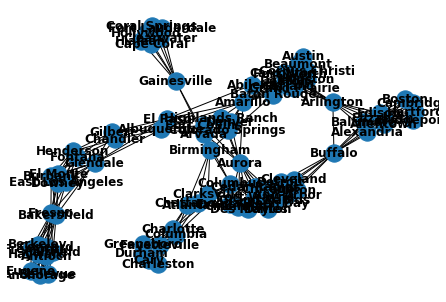

In [84]:
networkx.draw(graph, with_labels=True, font_weight='bold')

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables

In [85]:

# convert NetworkX object to PyTorch Geometric form
data = tg.utils.convert.from_networkx(graph)

In [28]:
print(data.keys)
# print(data.x)
# data.num_node_features = 2
print(data.num_node_features)

['x', 'edge_index', 'y', 'distance']
2


In [29]:
data.keys

['x', 'edge_index', 'y', 'distance']

In [86]:
# First trail - try to learn altitude by proximity and average temp

import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

# Builtin message function that computes message using source node feature.
gcn_msg = fn.copy_src(src='h', out='m')  

# TODO need to figure out aggregation function that takes edge weights into consideration!!!!!
# Builtin reduce function that aggregates messages by sum.
gcn_reduce = fn.sum(msg='m', out='h')    # reduce function


# for each node u, aggregate neighbors' representations to produce intermediate representations.
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(2, 2)
        self.layer2 = GCNLayer(2, 1)

    def forward(self, g, features):
        x = F.leaky_relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

net = Net()
print(net)



Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=2, out_features=2, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=2, out_features=1, bias=True)
  )
)


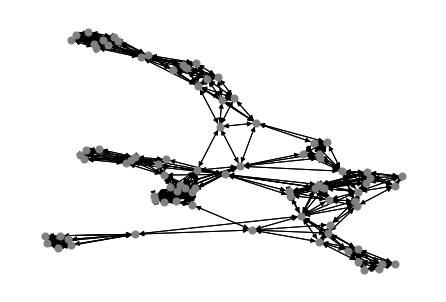

DGLGraph(num_nodes=85, num_edges=813,
         ndata_schemes={'x': Scheme(shape=(2,), dtype=torch.float64), 'y': Scheme(shape=(1,), dtype=torch.float64)}
         edata_schemes={'distance': Scheme(shape=(1,), dtype=torch.float64)})


In [120]:
 # https://docs.dgl.ai/tutorials/basics/3_pagerank.html
# https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html
g = dgl.DGLGraph()

# https://docs.dgl.ai/generated/dgl.DGLGraph.from_networkx.html?highlight=from_networkx
g.from_networkx(nx_graph=graph, edge_attrs=['distance'], node_attrs=['x', 'y'])

nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

print(g)

In [121]:
 # AK this is a bad evaluation method, think of something different...
 
 def evaluate(model, g, features, labels):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits
        labels = labels
        # _, indices = torch.max(logits, dim=1)
        # correct = torch.sum(indices == labels)
        # return correct.item() * 1.0 / len(labels)
        return torch.mean(torch.abs(logits-labels))

In [128]:
import time
import numpy as np

features = torch.FloatTensor(g.ndata['x'].float())
labels = torch.LongTensor(g.ndata['y'].long())

num_epochs = len(g)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
dur = []
for epoch in range(num_epochs):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logits = F.leaky_relu(logits)
    # logp = F.log_softmax(logits, 1)
    # loss = F.nll_loss(logp, labels.squeeze())

    # tried these
    # loss = F.mse_loss(logits, labels.float())
    # loss = F.binary_cross_entropy_with_logits(logits, labels.float())
    loss = F.smooth_l1_loss(logits, labels.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    if epoch % 5 == 0:
        acc = evaluate(net, g, features, labels)
        print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, np.mean(dur)))

Epoch 00000 | Loss 451.3847 | Test Acc 3742.9700 | Time(s) nan
Epoch 00005 | Loss 371.3807 | Test Acc 624.0861 | Time(s) 0.0043
Epoch 00010 | Loss 372.5627 | Test Acc 561.4609 | Time(s) 0.0042
Epoch 00015 | Loss 398.0206 | Test Acc 905.9975 | Time(s) 0.0040
Epoch 00020 | Loss 370.6904 | Test Acc 599.0085 | Time(s) 0.0038
Epoch 00025 | Loss 371.7765 | Test Acc 619.4227 | Time(s) 0.0037
Epoch 00030 | Loss 371.6510 | Test Acc 595.2872 | Time(s) 0.0037
Epoch 00035 | Loss 369.5255 | Test Acc 612.2726 | Time(s) 0.0036
Epoch 00040 | Loss 374.0493 | Test Acc 575.0546 | Time(s) 0.0036
Epoch 00045 | Loss 372.1080 | Test Acc 579.5936 | Time(s) 0.0036
Epoch 00050 | Loss 369.5753 | Test Acc 580.9139 | Time(s) 0.0036
Epoch 00055 | Loss 369.4807 | Test Acc 585.4514 | Time(s) 0.0037
Epoch 00060 | Loss 368.6850 | Test Acc 627.6742 | Time(s) 0.0037
Epoch 00065 | Loss 371.7403 | Test Acc 616.4580 | Time(s) 0.0037
Epoch 00070 | Loss 368.0358 | Test Acc 633.8454 | Time(s) 0.0037
Epoch 00075 | Loss 369.8610

In [130]:
j=20
print(logits[j])
print(labels[j])


tensor([87.8413], grad_fn=<SelectBackward>)
tensor([107])


In [ ]:
## USED FOR UNDERSTANDING :

In [46]:
from dgl.data import citation_graph as citegrh
import networkx as nx

data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labels = th.LongTensor(data.labels)
train_mask = th.BoolTensor(data.train_mask)
test_mask = th.BoolTensor(data.test_mask)
g = DGLGraph(data.graph)
# g, features, labels, train_mask, test_mask

Extracting file to C:\Users\Asaf Karnieli\.dgl/cora


(DGLGraph(num_nodes=2708, num_edges=10556,
          ndata_schemes={}
          edata_schemes={}),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([2, 5, 4,  ..., 1, 0, 2]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([False, False, False,  ..., False, False, False]))